In [1]:
# Import các thư viện cần thiết
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
# Hàm trích xuất đặc trưng MFCC
def extract_mfcc(audio, sr=16000, n_mfcc=13):
    hop_length = int(0.01 * sr)  # 10 ms hop
    win_length = int(0.025 * sr)  # 25 ms window
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, win_length=win_length)
    return np.mean(mfcc.T, axis=0)  # Lấy giá trị trung bình theo trục thời gian

# Hàm tải và xử lý dữ liệu từ thư mục
def load_data(data_dir):
    X = []
    y = []
    labels = os.listdir(data_dir)
    for label in labels:
        label_dir = os.path.join(data_dir, label)
        for file_name in os.listdir(label_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(label_dir, file_name)
                # Tải tệp âm thanh
                audio, sr = librosa.load(file_path, sr=None)
                # Trích xuất đặc trưng MFCC
                features = extract_mfcc(audio, sr)
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)


In [3]:
# Load dữ liệu huấn luyện và kiểm tra
train_data_dir = r'C:\Users\USER\Downloads\SV_NCKH_audio_event\Train'
test_data_dir = r'C:\Users\USER\Downloads\SV_NCKH_audio_event\Test'

X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)

# Mã hóa nhãn bằng LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển đổi nhãn thành dạng one-hot encoding
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [5]:
# Xây dựng mô hình ANN
def create_ann_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))  # Lớp ẩn đầu tiên
    model.add(Dropout(0.5))  # Dropout để giảm overfitting
    model.add(Dense(64, activation='relu'))  # Lớp ẩn thứ hai
    model.add(Dense(num_classes, activation='softmax'))  # Lớp đầu ra
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Khởi tạo mô hình ANN
input_dim = X_train.shape[1]  # Số đặc trưng đầu vào
model = create_ann_model(input_dim, num_classes)

# Hiển thị kiến trúc của mô hình
model.summary()

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,413 (44.58 KB)

 Trainable params: 11,413 (44.58 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Huấn luyện mô hình
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# Đánh giá mô hình
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Dự đoán và báo cáo
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1427 - loss: 2.8522 - val_accuracy: 0.3704 - val_loss: 2.1100
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4222 - loss: 1.9863 - val_accuracy: 0.4458 - val_loss: 1.7286
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5206 - loss: 1.5734 - val_accuracy: 0.5364 - val_loss: 1.5973
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5679 - loss: 1.3574 - val_accuracy: 0.5638 - val_loss: 1.5496
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6134 - loss: 1.2525 - val_accuracy: 0.5610 - val_loss: 1.5229
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6216 - loss: 1.2070 - val_accuracy: 0.5912 - val_loss: 1.4639
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6066 - loss: 1.1616 - val_accuracy: 0.5857 - val_loss: 1.4513
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6562 - loss: 1.0677 - val_accuracy: 0.5898 - val_loss

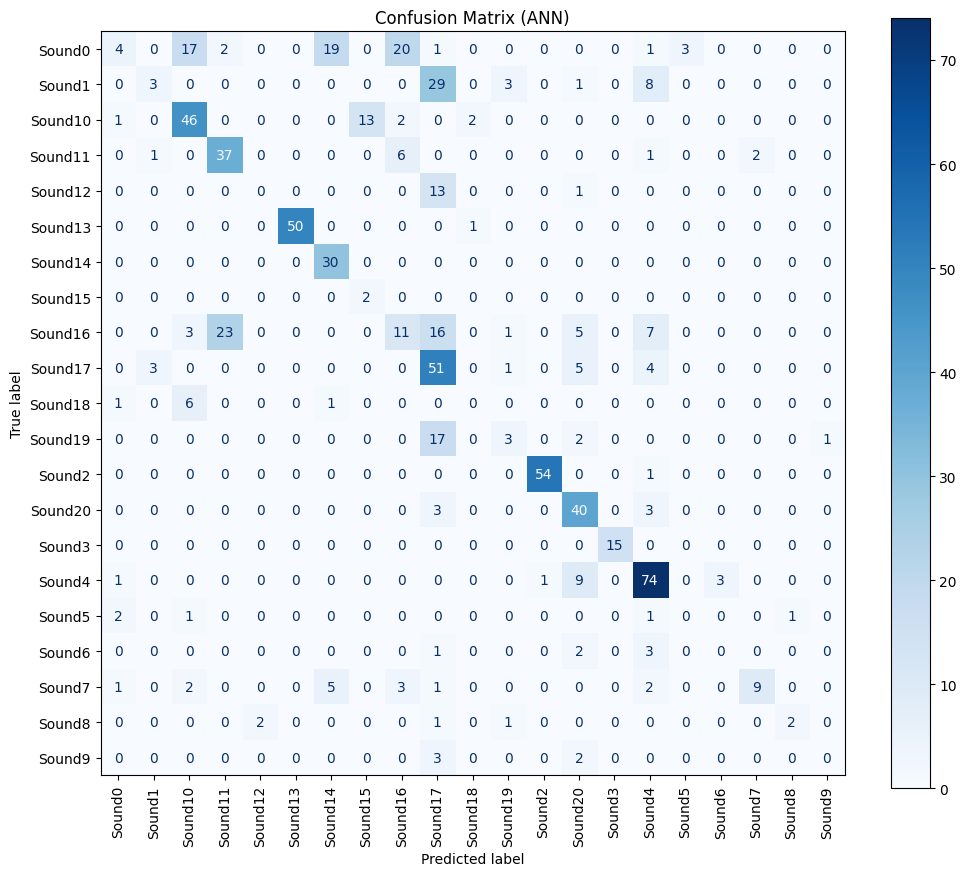

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Vẽ ma trận nhầm lẫn
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix (ANN)")
plt.show()